In [9]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime, pytz
from scipy.stats import boxcox

from itertools import product
from numpy.linalg import LinAlgError

In [53]:
def dateparse (time_in_secs): 
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))
data = pd.read_csv('Data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',parse_dates=[0], date_parser=dateparse) 

In [54]:
start

datetime.datetime(2013, 1, 1, 0, 0, tzinfo=<UTC>)

In [55]:
start = datetime.datetime(2013, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2019, 11, 11, 0, 0, 0, 0, pytz.UTC)

data = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
#data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

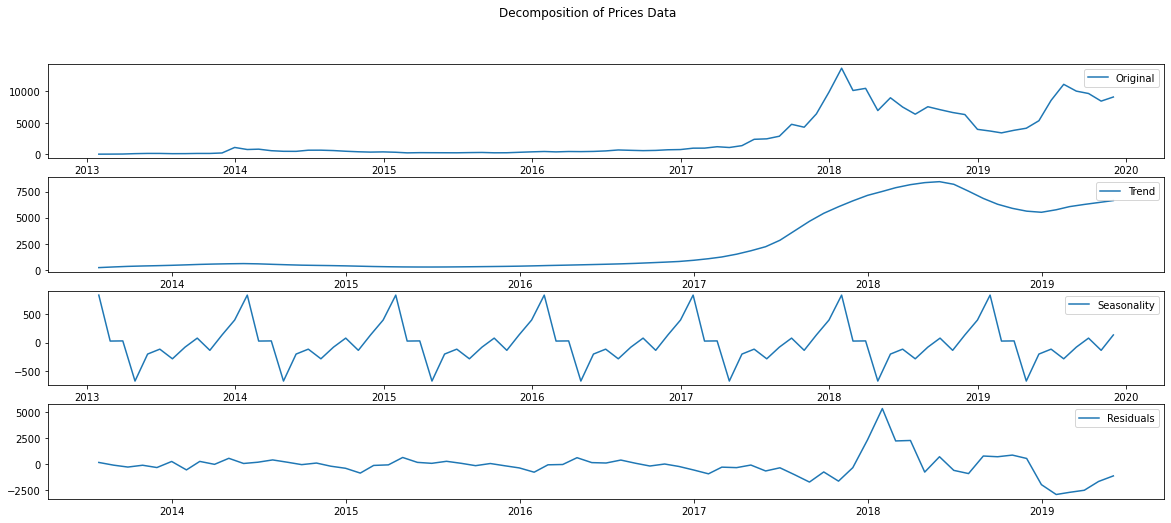

In [56]:
decomposition = sm.tsa.seasonal_decompose(data.Weighted_Price)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [57]:
def decompose(series):
    plt.figure(figsize = (14,7))
    seasonal_decompose(series).plot()
    plt.show()
    
def DFTest(series):
    testdf = adfuller(series)
    print("DF test p-value : %.16f" %testdf[1] )
    
    
def plots(series):
    plt.figure(figsize = (10,6))
    sns.lineplot(data = series, color = 'blue', label = 'observed line plot')
    sns.lineplot(data = series.rolling(window = 12).mean(), color = 'green', label = 'rolling mean, window -12')
    sns.lineplot(data = series.rolling(window = 12).std(), color = 'black', label = 'std deviation, window -12')

DF test p-value : 0.7748062567138039


<Figure size 1008x504 with 0 Axes>

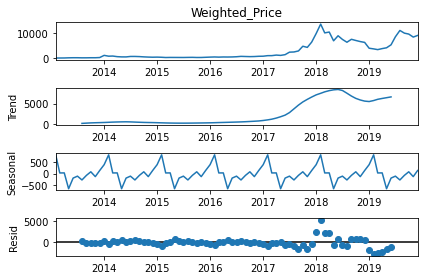

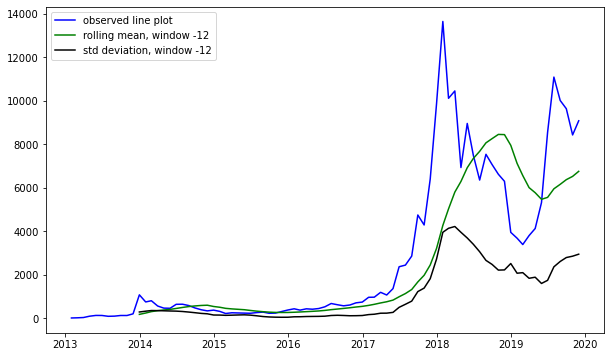

In [58]:
#running tests
DFTest(data.Weighted_Price)
decompose(data.Weighted_Price)
plots(data.Weighted_Price)

DF test p-value : 0.1443278443474916


<Figure size 1008x504 with 0 Axes>

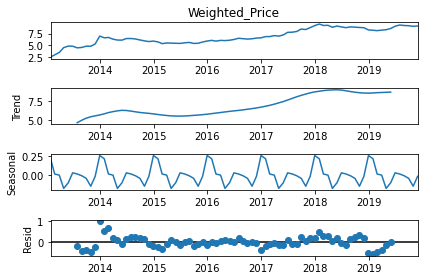

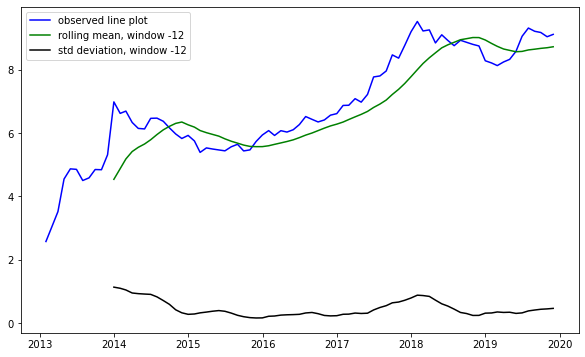

In [59]:
prices = data.Weighted_Price
prices_log = np.log(prices)

#running tests
DFTest(prices_log)
decompose(prices_log)
plots(prices_log)

DF test p-value : 0.0000000000395569


<Figure size 1008x504 with 0 Axes>

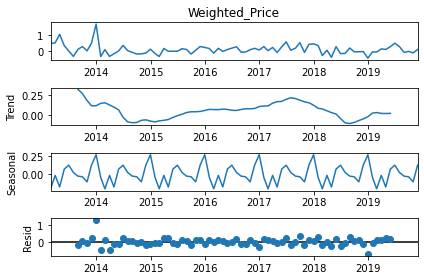

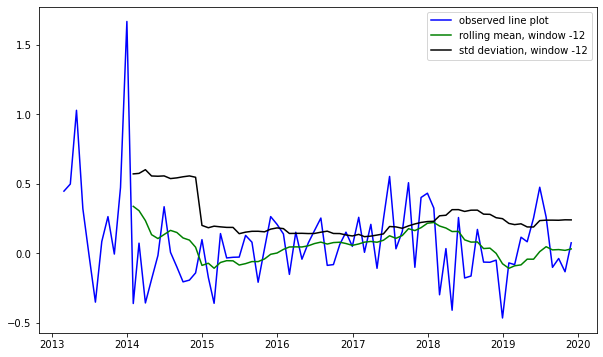

In [60]:
prices_log_r = prices_log - prices_log.shift(1)
prices_log_r.dropna(inplace = True)

DFTest(prices_log_r)
decompose(prices_log_r)
plots(prices_log_r)

<Figure size 1008x504 with 0 Axes>

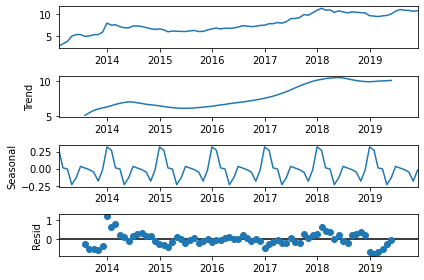

DF test p-value : 0.2348046306280135
lambda value: 0.03384400281753128


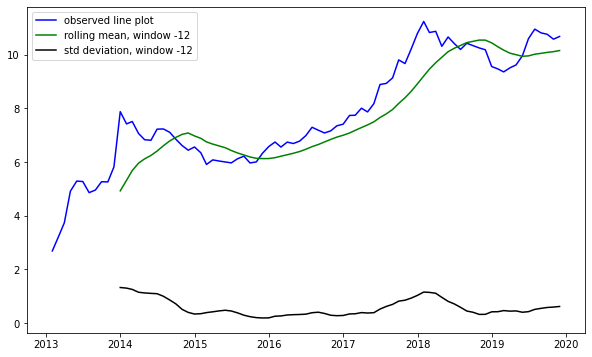

In [61]:
prices_box_cox_, lambda_ = boxcox(prices)
prices_box_cox = pd.Series(data = prices_box_cox_, index = data.index) #decompose functions requires a pandas object that has a timestamp index.

decompose(prices_box_cox) 
DFTest(prices_box_cox)
print('lambda value:', lambda_)
plots(prices_box_cox)

<Figure size 1008x504 with 0 Axes>

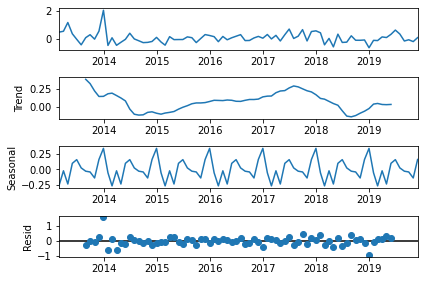

DF test p-value : 0.0000000000184016


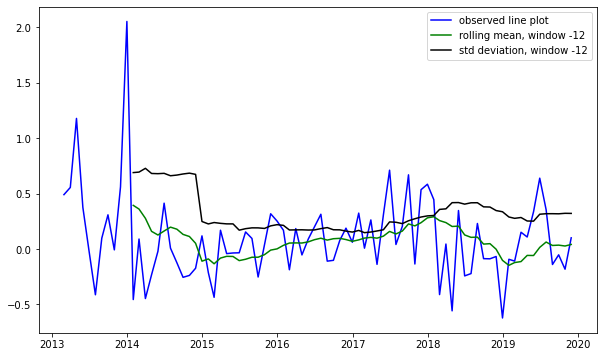

In [62]:
prices_box_cox_r = prices_box_cox - prices_box_cox.shift(1)
prices_box_cox_r.dropna(inplace = True)

decompose(prices_box_cox_r) 
DFTest(prices_box_cox_r)
plots(prices_box_cox_r)

In [63]:
print('Original prices')
print(DFTest(prices))
print('Log Transformation')
print(DFTest(prices_log))
print('Regular time shift applied to Log transformed prices')
print(DFTest(prices_log_r))
print('Box Cox power transform')
print(DFTest(prices_box_cox))
print('Regular time shift applied on Box Cox Transformed prices')
print(DFTest(prices_box_cox_r))

Original prices
DF test p-value : 0.7748062567138039
None
Log Transformation
DF test p-value : 0.1443278443474916
None
Regular time shift applied to Log transformed prices
DF test p-value : 0.0000000000395569
None
Box Cox power transform
DF test p-value : 0.2348046306280135
None
Regular time shift applied on Box Cox Transformed prices
DF test p-value : 0.0000000000184016
None


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


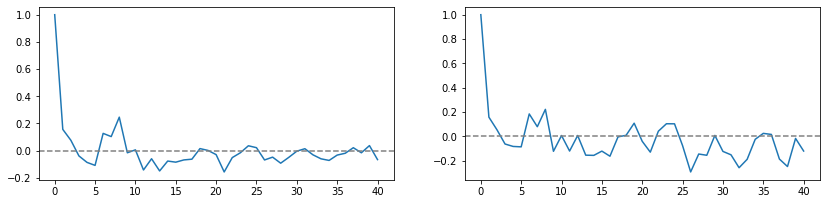

In [64]:
plt.figure(figsize = (14,7)) 
a = acf(prices_box_cox_r)
p = pacf(prices_box_cox_r)

plt.subplot(221)
sns.lineplot(data = a)
plt.axhline(y=0, linestyle='--', color='gray')

plt.subplot(222)
sns.lineplot(data = p)
plt.axhline(y=0, linestyle='--', color='gray')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

Rejected Parameters: (1, 1, 3)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

(1, 1, 1) 83.38131261136255
[[(1, 1, 1), 83.38131261136255], [(1, 1, 2), 86.9722874880186], [(2, 1, 1), 85.06409362332144], [(2, 1, 2), 85.25034071029071], [(2, 1, 3), 88.35868394083408], [(3, 1, 1), 86.92960465686252], [(3, 1, 2), 88.76994360794717], [(3, 1, 3), 83.4118883830755]]
Timestamp
2013-03-31   -0.002000
2013-04-30   -0.030155
2013-05-31   -0.362497
2013-06-30    0.210749
2013-07-31    0.427261
                ...   
2019-07-31   -0.515548
2019-08-31   -0.275065
2019-09-30    0.136548
2019-10-31    0.060818
2019-11-30    0.165952
Length: 81, dtype: float64


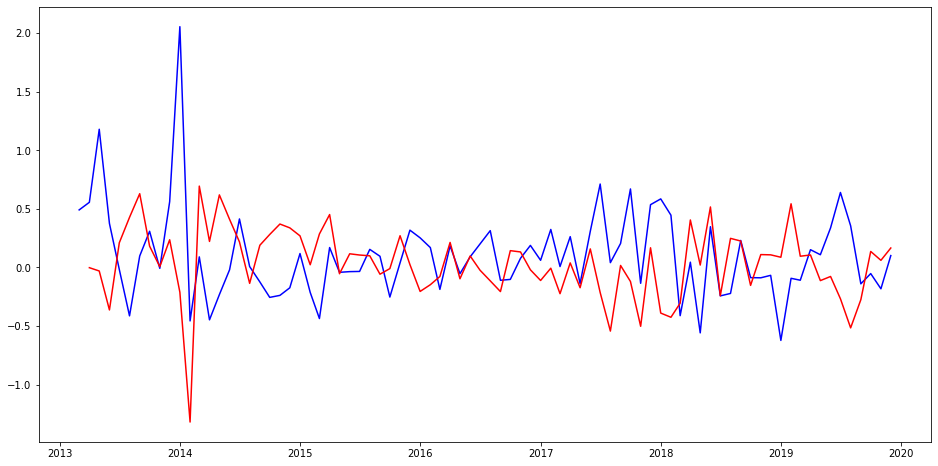

In [66]:
a = [[1,2,3], [1],[1,2,3]]
params = list(product(*a))

results = []   
min_aic = float('inf')
best_param = []

# checking different set of params for best fit
for param in params:
    try:
        model = ARIMA(prices_box_cox_r, order = param).fit(disp = -1)
    except LinAlgError:
        print('Rejected Parameters:', param)
        continue
    except ValueError:
        print('Rejected Parameters:', param)
        continue
    if(min_aic > model.aic):
        min_aic = model.aic
        best_param = param
        best_model = model
        
    results.append([param, model.aic])

print(best_param,min_aic)
print(results)

print(best_model.fittedvalues)

plt.figure(figsize=(16,8))
sns.lineplot(data = prices_box_cox_r, color = 'blue')
sns.lineplot(data = best_model.fittedvalues, color = 'red') 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


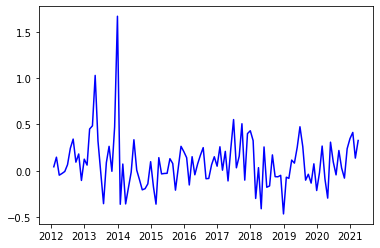

In [44]:
fitted_values = best_model.fittedvalues
fitted_values = fitted_values.cumsum()

fitted_values = fitted_values + prices_log[0]

final_values = np.exp(fitted_values)

d = {'prices' : prices, 'prices_log' : prices_log, 'prices' : prices_log_r, 'fitted_values' : fitted_values, 'final_values' : final_values}
summaryDF = pd.DataFrame(data = d)
sns.lineplot(data = summaryDF['prices'], color = 'blue')
sns.lineplot(data = summaryDF['final_values'], color = 'red')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


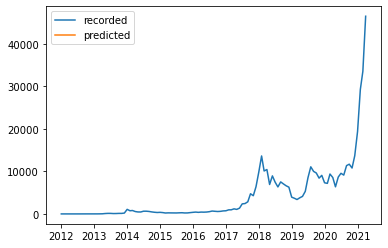

In [45]:
predicted_values = np.exp((best_model.predict(start = 1, end = 99).cumsum()) + prices_box_cox_r[0])
sns.lineplot(data = prices, label  = 'recorded')
sns.lineplot(data = predicted_values, label = 'predicted')